In [2]:
!pip install -q yfinance

  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/58/f7/a966b800b49cb5379e348bf0717df481051714a99ece15289718562f6952/yfinance-0.2.35-py2.py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 56.1 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 6.0 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.0-cp310-cp310-linux_x86_64.whl size=290465 sha256=23ae43ccc5057e874bdd7ad85b0770eab2440bda3b3532bc7e87157baf86328a
  Stored in directory: /root/.cache/pip/wheels/c7/70/ad/212867e96e7004265a69c4aa5dcff00a95f547a67ba26e7e76
Successfully built peewee


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import datetime as dt
import warnings


# Ignore all warnings
warnings.filterwarnings("ignore")

# **Basic Functions**

In [2]:
# Function to download stock data using yfinance
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Function to prepare data for modeling
def prepare_data(stock_data):
    # Considering 'Close' prices for analysis
    data = stock_data['Close'].values
    return data

# Function to split data into train and test sets
def split_data(data):
    train_size = int(len(data) * 0.8)
    train_data, test_data = data[:train_size], data[train_size:]
    return train_data, test_data

# Function to train ARIMA model
def train_arima(train_data, test_data):
    history = list(train_data)
    predictions = []
    for t in range(len(test_data)):
        model = ARIMA(history, order=(5,0,0)) # ARIMA model with order (p,d,q)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(yhat)
    return predictions

# Function to train MLP model
def train_mlp(train_data, test_data):
    # Prepare train and test data for MLP
    X_train, y_train = [], []
    for i in range(len(train_data)-1):
        X_train.append(train_data[i:i+1])
        y_train.append(train_data[i+1])
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    X_test = []  # Update test data preparation
    for i in range(len(test_data)):
        X_test.append(test_data[i:i+1])
    X_test = np.array(X_test)
    
    mlp = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000)
    mlp.fit(X_train, y_train)
    
    # Predict the next step after the test set ends
    # next_step_prediction = mlp.predict(X_test[-1:])  # Predict for the next step
    
    # Extend the predictions
    # mlp_predictions = np.concatenate((mlp.predict(X_test), next_step_prediction))
    mlp_predictions = mlp.predict(X_test)
    
    return mlp_predictions

# Function to evaluate model performance
def evaluate_model(test_data, predictions):
    mse = mean_squared_error(test_data, predictions)
    return mse

# **II- Basic Scenario**

### **Downloading the stocks data**

In [3]:
# Download stock data
ticker = 'AAPL'  # Change to desired stock ticker
start_date = '2019-01-01'
end_date = '2023-01-01'
stock_data = get_stock_data(ticker, start_date, end_date)

# Prepare data
data = prepare_data(stock_data)

# Split data into train and test sets
train_data, test_data = split_data(data)

[*********************100%%**********************]  1 of 1 completed


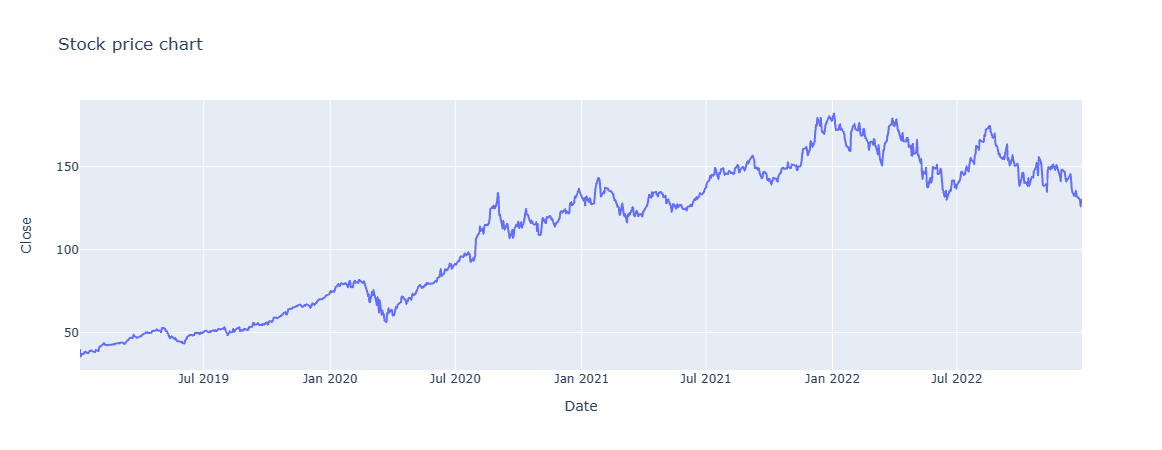

In [4]:
fig = px.line(stock_data,  y="Close", title='Stock price chart')
fig.show()

## **Data preprocessing**

In [5]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [6]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## 1- LSTM

In [7]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()




Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm (LSTM)                 (None, 60, 100)           40800     

                                                                 

 lstm_1 (LSTM)               (None, 100)               80400     

                                                                 

 dense (Dense)               (None, 25)                2525      

                                                                 

 dense_1 (Dense)             (None, 1)                 26        

                                                                 


Total params: 123751 (483.40 KB)

Trainable params: 123751 (483.40 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)




Epoch 1/3




747/747 [==============================] - 25s 28ms/step - loss: 0.0035

Epoch 2/3

747/747 [==============================] - 19s 26ms/step - loss: 0.0016

Epoch 3/3

747/747 [==============================] - 19s 25ms/step - loss: 0.0011


In [9]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

7/7 [==============================] - 1s 28ms/step


1.8690532095989778

In [10]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

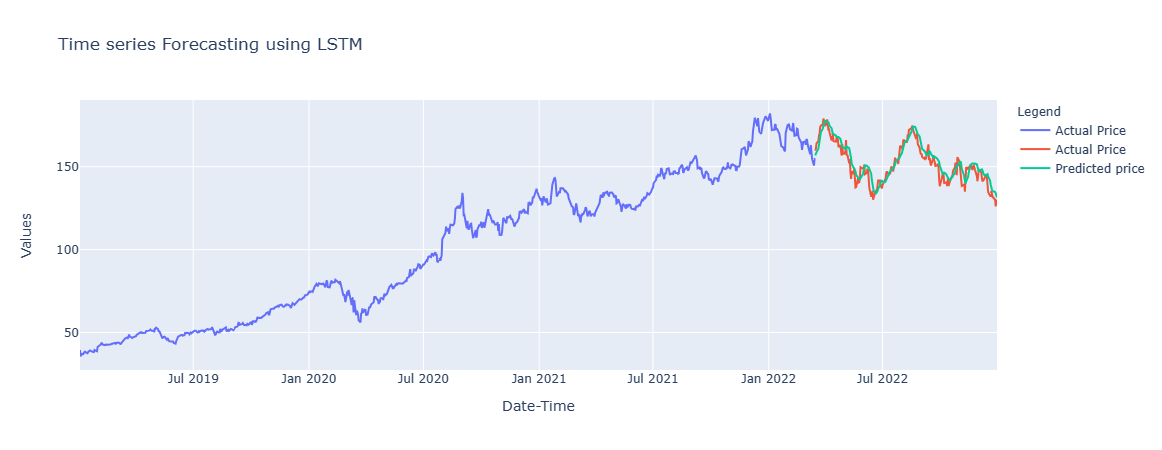

In [11]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='Predicted price'))
fig.update_layout(
        title="Time series Forecasting using LSTM",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

## 2- ARIMA

In order to use the **ARIMA** model, we need to estimate the parameters p, d and q.
To have the optimal parameters, it is necessary to observe the autocorrelation and partial autocorrelation plots.

In [12]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.8)

data = values.reshape(-1,1)
train_data = data[0: training_data_len]
test_data = data[training_data_len:]

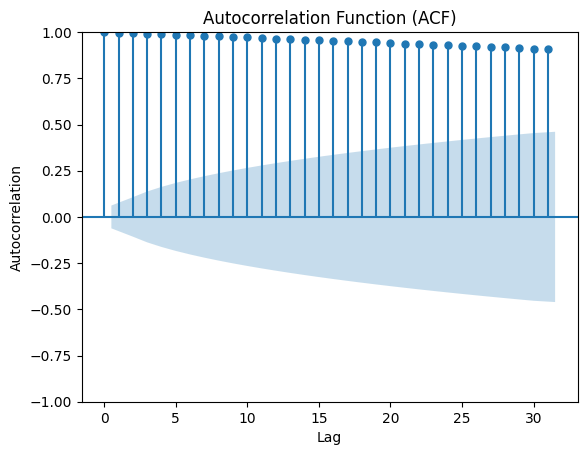

In [13]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF
plot_acf(data)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF)')
plt.show()

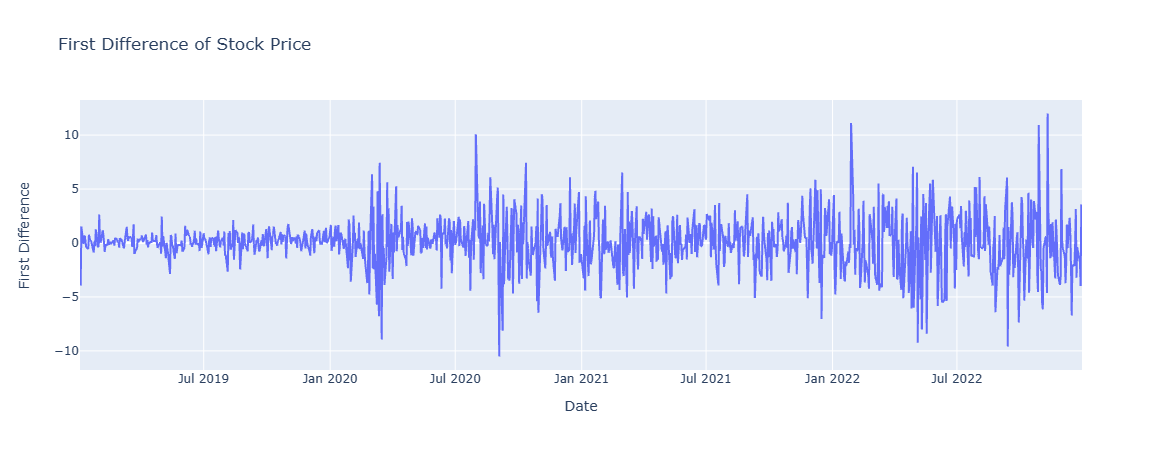

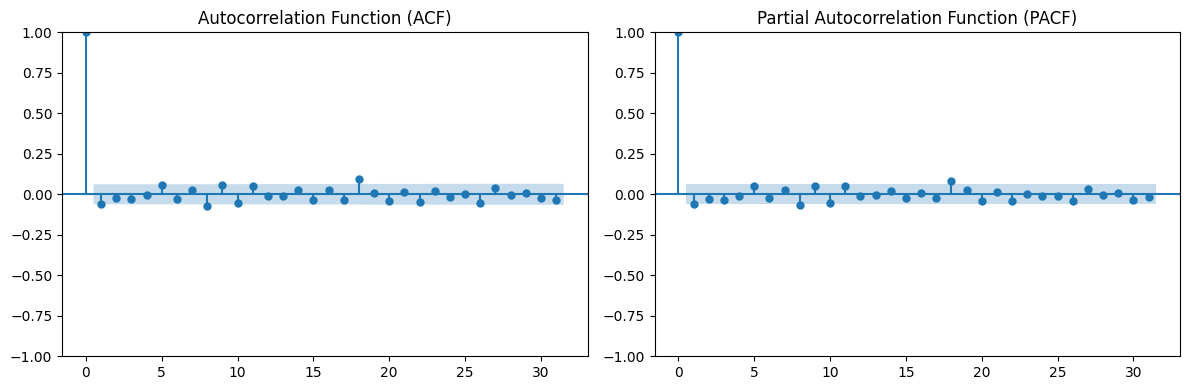

In [14]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

# Calculate the first difference
stock_data['First Difference'] = stock_data['Close'].diff()

# Plot the first difference
fig = px.line(stock_data, y='First Difference', title='First Difference of Stock Price')
fig.show()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF on the first subplot (ax1)
plot_acf(stock_data['First Difference'].dropna(), ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot (ax2)
plot_pacf(stock_data['First Difference'].dropna(), ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()  # Adjusts subplot parameters for better layout
plt.show()

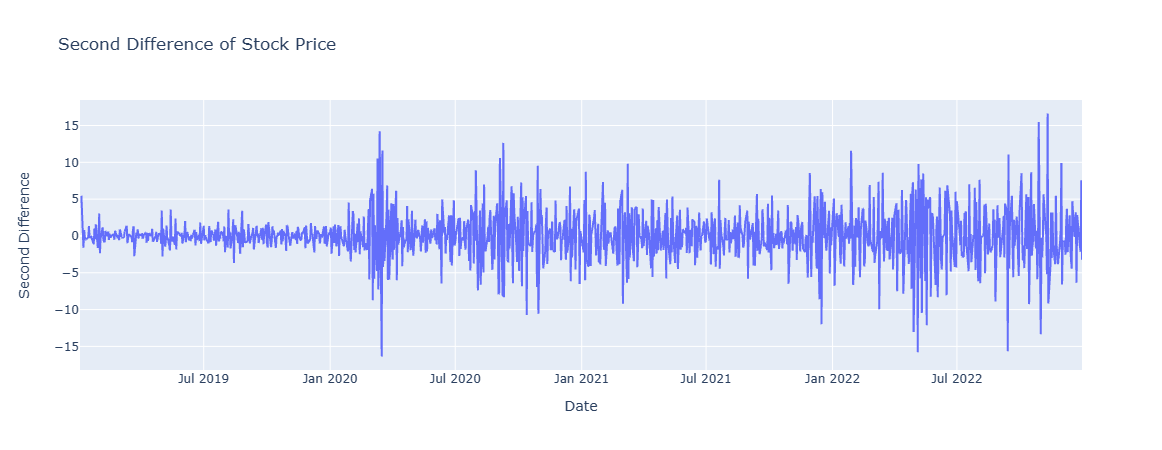

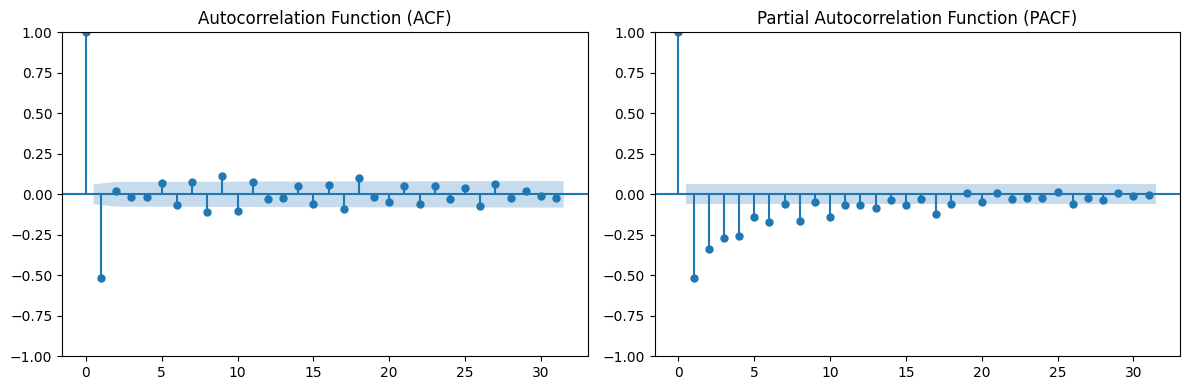

In [15]:
# Calculate the second difference
stock_data['Second Difference'] = stock_data['First Difference'].diff()

# Plot the first difference
fig = px.line(stock_data, y='Second Difference', title='Second Difference of Stock Price')
fig.show()

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot ACF on the first subplot (ax1)
plot_acf(stock_data['Second Difference'].dropna(), ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF on the second subplot (ax2)
plot_pacf(stock_data['Second Difference'].dropna(), ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()  # Adjusts subplot parameters for better layout
plt.show()

In [16]:
p,d,q = 6, 2, 3
history = stock_data["Close"]
start_index, end_index = training_data_len, stock_data["Close"].shape[0]
model = ARIMA(history, order=(p,d,q))
model_fit = model.fit()
predictions = model_fit.predict(start= stock_data["Close"].index[start_index], end=stock_data["Close"].index[end_index-1])

# Evaluate using RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))

In [17]:
data = stock_data.filter(['Close'])
train = data[:len(train_data)]
validation = data[len(train_data):]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

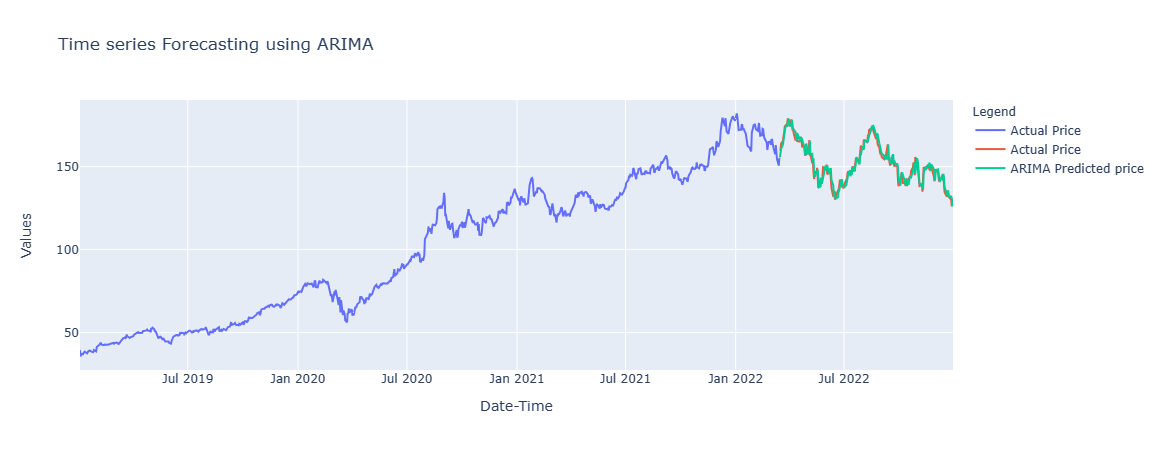

In [18]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='ARIMA Predicted price'))
fig.update_layout(
        title="Time series Forecasting using ARIMA",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

## 3- MLP

In [20]:
# Function to train MLP model
def train_mlp_ts(X_train, y_train, X_test):

    
    mlp = MLPRegressor(hidden_layer_sizes=(50,50), max_iter=1000)
    mlp.fit(X_train, y_train)
    
    mlp_predictions = mlp.predict(X_test)
    
    return mlp_predictions

In [20]:
mlp_predictions = train_mlp_ts(x_train[:,:,0], y_train, x_test[:,:,0])

In [21]:
mlp_predictions = scaler.inverse_transform(mlp_predictions.reshape(1,-1))
rmse = np.sqrt(np.mean(mlp_predictions - y_test)**2)
rmse

5.813183018616338

In [22]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = mlp_predictions[0]
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

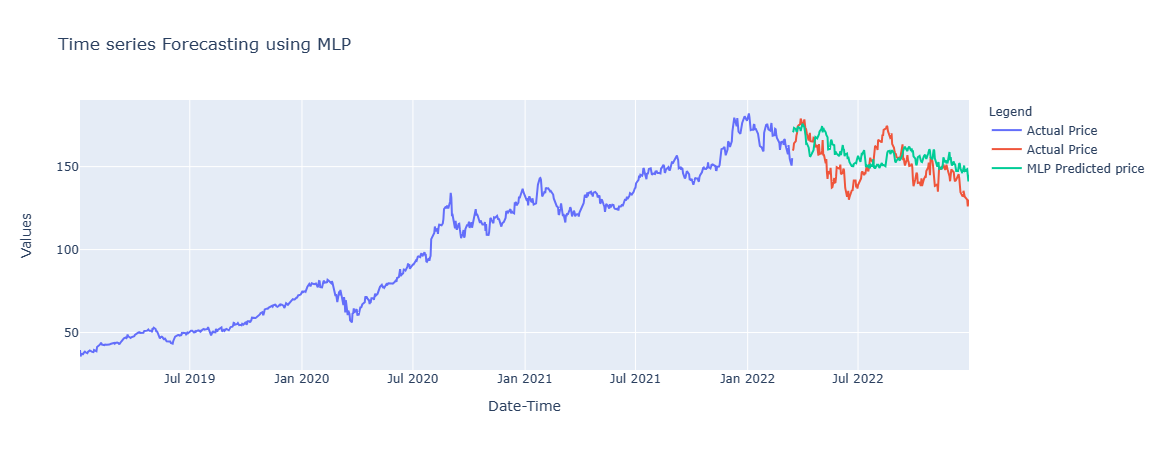

In [23]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='MLP Predicted price'))
fig.update_layout(
        title="Time series Forecasting using MLP",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

In [24]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.4)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [25]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 lstm_2 (LSTM)               (None, 60, 100)           40800     

                                                                 

 lstm_3 (LSTM)               (None, 100)               80400     

                                                                 

 dense_2 (Dense)             (None, 25)                2525      

                                                                 

 dense_3 (Dense)             (None, 1)                 26        

                                                                 


Total params: 123751 (483.40 KB)

Trainable params: 123751 (483.40 KB)

Non-trainable params: 0 (0.00 Byte)

_________________________________________________________________


In [26]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3

344/344 [==============================] - 17s 35ms/step - loss: 0.0012

Epoch 2/3

344/344 [==============================] - 12s 35ms/step - loss: 8.0014e-04

Epoch 3/3

344/344 [==============================] - 12s 34ms/step - loss: 6.8759e-04


In [27]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

19/19 [==============================] - 2s 38ms/step


13.485294354672464

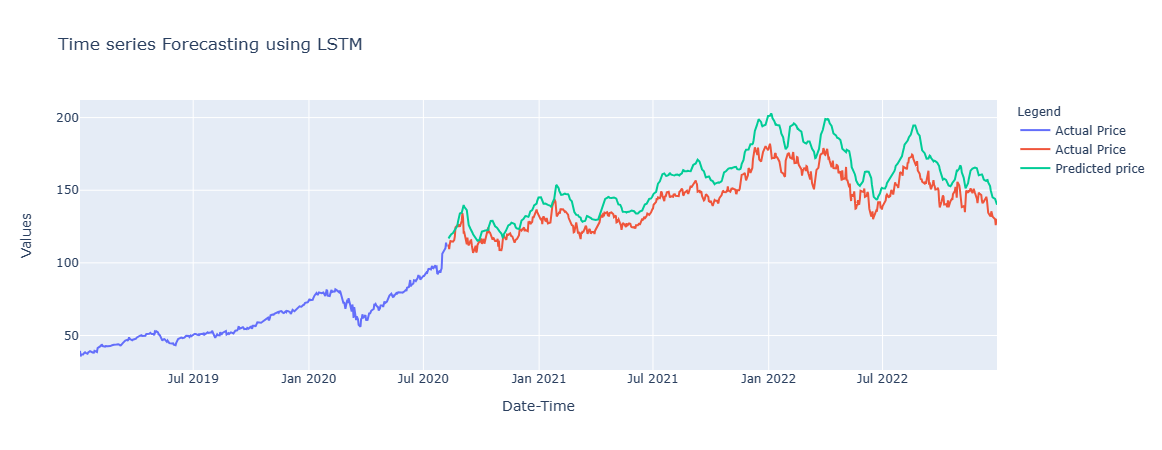

In [28]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='Predicted price'))
fig.update_layout(
        title="Time series Forecasting using LSTM",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

In [29]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.4)

data = values.reshape(-1,1)
train_data = data[0: training_data_len]
test_data = data[training_data_len:]

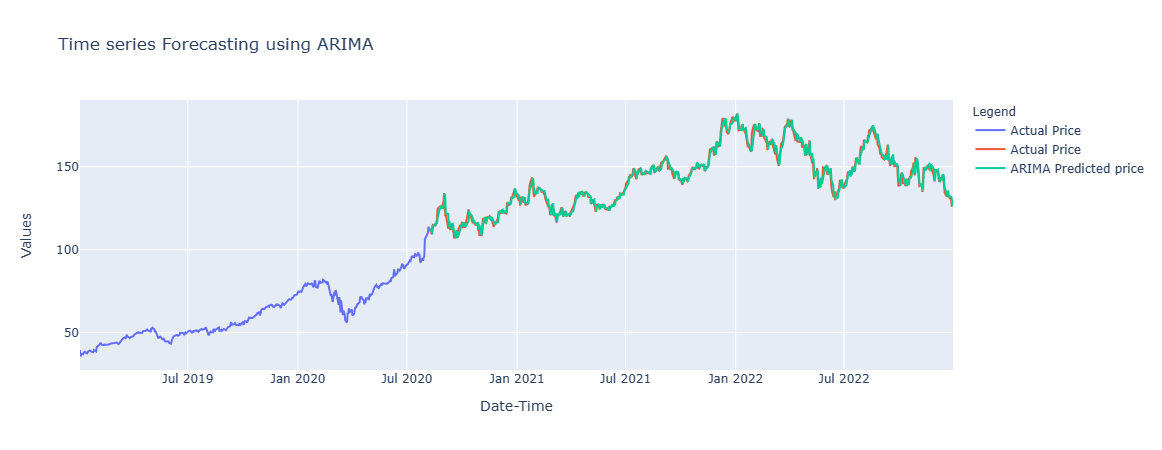

In [30]:
p,d,q = 6, 2, 3
history = stock_data["Close"]
start_index, end_index = training_data_len, stock_data["Close"].shape[0]
model = ARIMA(history, order=(p,d,q))
model_fit = model.fit()
predictions = model_fit.predict(start= stock_data["Close"].index[start_index], end=stock_data["Close"].index[end_index-1])

# Evaluate using RMSE
rmse = np.sqrt(mean_squared_error(test_data, predictions))

data = stock_data.filter(['Close'])
train = data[:len(train_data)]
validation = data[len(train_data):]
validation['Predictions'] = predictions
train.reset_index(inplace = True)
validation.reset_index(inplace = True)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Close, mode='lines', name='Actual Price'))
fig.add_trace(go.Scatter(x=validation.Date, y=validation.Predictions, mode='lines', name='ARIMA Predicted price'))
fig.update_layout(
        title="Time series Forecasting using ARIMA",
        xaxis_title="Date-Time",
        yaxis_title="Values",
        legend_title="Legend",
)
fig.show()

# **II- Failure Dataset**

In [231]:
WORKING_DIR = "/kaggle/input/microsoft-azure-predictive-maintenance/"

df_tele = pd.read_csv(WORKING_DIR + 'PdM_telemetry.csv')
df_fail = pd.read_csv(WORKING_DIR + 'PdM_failures.csv')

In [226]:
df_fail['machineID'].value_counts()

machineID
99     19
98     16
22     15
17     15
83     14
       ..
100     3
46      2
29      2
72      2
57      2
Name: count, Length: 98, dtype: int64

In [227]:
# print the top 5 rows from the failure dataframe
df_fail[df_fail["machineID"]==99]

,datetime,machineID,failure
739,2015-01-02 03:00:00,99,comp3
740,2015-01-18 06:00:00,99,comp4
741,2015-02-02 06:00:00,99,comp1
742,2015-02-17 06:00:00,99,comp2
743,2015-03-04 06:00:00,99,comp3
744,2015-03-19 06:00:00,99,comp4
745,2015-04-03 06:00:00,99,comp2
746,2015-04-18 06:00:00,99,comp3
747,2015-05-03 06:00:00,99,comp2
748,2015-05-18 06:00:00,99,comp1


# 1. Telemetry

In [232]:
data_mach3 = df_tele

# Convert 'datetime column to satandard datetime format   yyyy-mm-dd HH:MM:SS'
data_mach3['datetime'] = pd.to_datetime(data_mach3['datetime'])

# set datatime column as index for the time series
data_mach3.set_index('datetime',inplace=True)
data_mach3.head()

# Consider Only 'volt' as a time series and only machine # 3
data_mach3 = data_mach3[['machineID','volt']]
data_mach3 = data_mach3[(data_mach3['machineID']==99)]
data_mach3 = data_mach3[['volt']]


fig = px.line(data_mach3['volt'],  y="volt", title='Volt time serie for Machine 3')
fig.show()

# Data preprocessing

In [233]:
data_mach3

,volt
datetime,
2015-01-01 06:00:00,168.596133
2015-01-01 07:00:00,153.667693
2015-01-01 08:00:00,178.319255
2015-01-01 09:00:00,162.163821
2015-01-01 10:00:00,180.201336
...,...
2016-01-01 02:00:00,166.719608
2016-01-01 03:00:00,168.434193
2016-01-01 04:00:00,191.505730


In [234]:
values = data_mach3["volt"].values

training_data_len = math.ceil(len(values)* 0.8)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [235]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

## 1.1. ARIMA

Predicted value for ARIMA  2015-11-01 01:00:00    170.264088
2015-11-01 02:00:00    170.038049
2015-11-01 03:00:00    170.296480
2015-11-01 04:00:00    171.014121
2015-11-01 05:00:00    169.511637
                          ...    
2016-01-31 21:00:00    170.361795
2016-01-31 22:00:00    170.361795
2016-01-31 23:00:00    170.361795
2016-02-01 00:00:00    170.361795
2016-02-01 01:00:00    170.361795
Freq: H, Name: predicted_mean, Length: 2209, dtype: float64


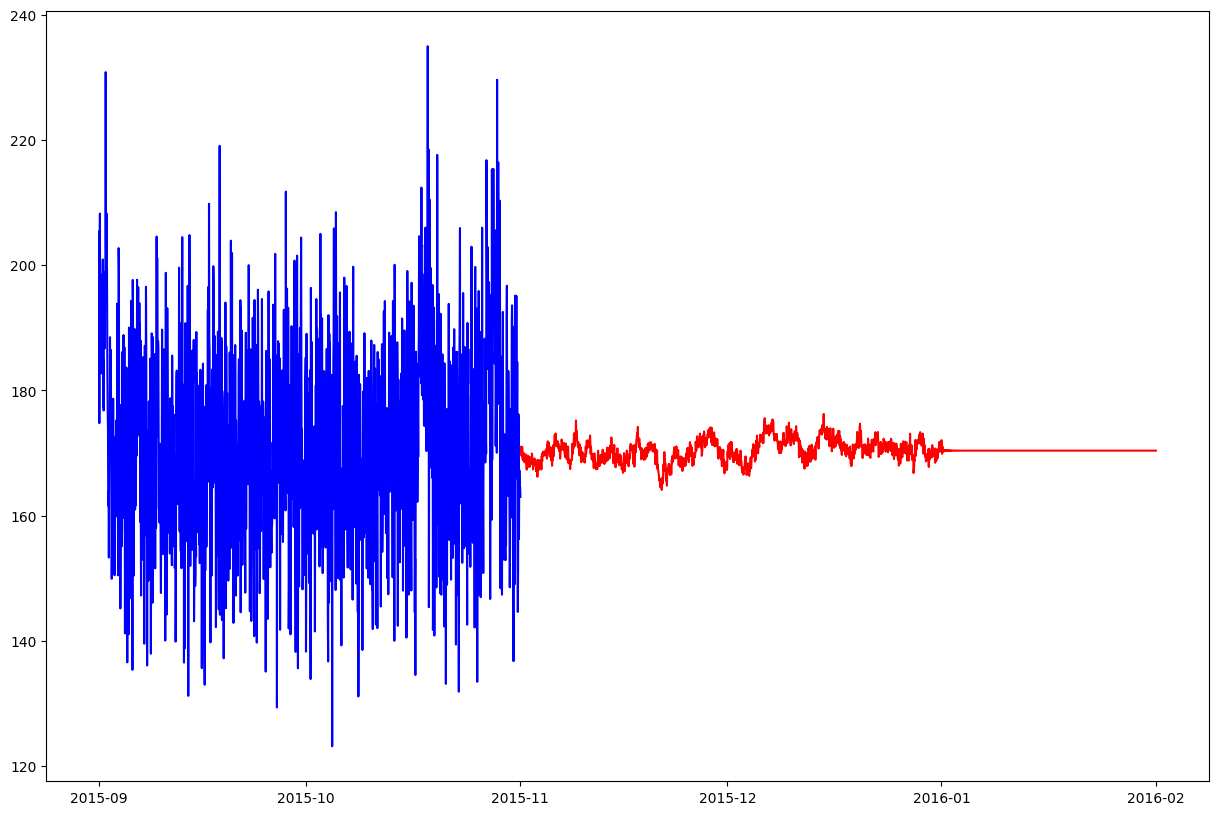

In [9]:
# import ARIMA class
from statsmodels.tsa.arima.model import ARIMA

df = data_mach3['volt']
# Define ARIMA model p=1,d=0 q=1
model = ARIMA(df, order=(2,1,2))
model_fit = model.fit()
#=================================
# Predict 3 months
y_predict = model_fit.predict( start= '2015-11-01 01:00:00', end = '2016-02-01 01:00:00' )
print('Predicted value for ARIMA ', y_predict)
plt.figure(figsize=(15,10))
plt.plot(y_predict,c='r',)

# Disply 1 month before
plt.plot(df.loc['2015-9-01 01:00:00':'2015-11-01 01:00:00'],c='b',)
plt.show()

## 1.2. LSTM

In [16]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           40800     
                                                                 
 lstm_1 (LSTM)               (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 25)                2525      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
6949/6949 [==============================] - 183s 26ms/step - loss: 0.0194
Epoch 2/3
6949/6949 [==============================] - 178s 26ms/step - loss: 0.0188
Epoch 3/3
6949/6949 [==============================] - 178s 26ms/step - loss: 0.0187


In [67]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

53/53 [==============================] - 1s 24ms/step


AttributeError: 'MinMaxScaler' object has no attribute 'min_'

## 1.3. MLP

In [236]:
# Function to train MLP model
def train_mlp_ts(X_train, y_train, X_test):

    mlp = MLPRegressor(hidden_layer_sizes=(10,10), max_iter=1000)
    mlp.fit(X_train, y_train)
    
    mlp_predictions = mlp.predict(X_test)
    
    return mlp_predictions

In [237]:
mlp_predictions = train_mlp_ts(x_train[:,:,0], y_train, x_test[:,:,0])
scaled_pred = mlp_predictions

In [238]:
mlp_predictions = scaler.inverse_transform(mlp_predictions.reshape(1,-1))
rmse = np.sqrt(np.mean(mlp_predictions - y_test)**2)
rmse

0.4971762191993486

# 2. Fail

## Data preparation

In [239]:
x_test = []

for i in range(60, len(scaled_pred)):
    x_test.append(scaled_pred[i-60:i])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [240]:
x_test.shape

(1692, 60, 1)

In [241]:
fail_mach3 = df_fail

# Convert 'datetime column to satandard datetime format   yyyy-mm-dd HH:MM:SS'
fail_mach3['datetime'] = pd.to_datetime(fail_mach3['datetime'])

# set datatime column as index for the time series
fail_mach3.set_index('datetime',inplace=True)
fail_mach3.head()

# Consider Only 'volt' as a time series and only machine # 3
fail_mach3 = fail_mach3[(fail_mach3['machineID']==99)]

In [254]:
failures = [1 if i in fail_mach3.index else 0 for i in data_mach3.index]

In [256]:
unique_values = set(failures)
print(unique_values)

{0, 1}


In [257]:
y_train = np.array(failures[:training_data_len-60])
y_test = np.array(failures[training_data_len+60:])

In [258]:
x_train.shape

(6949, 60, 1)

In [259]:
x_test.shape

(1692, 60, 1)

In [260]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

In [261]:
unique_values = set(y_train)
print("Unique values in y_test:")
print(unique_values)

Unique values in y_test:
{0, 1}


In [262]:
unique_values = set(y_test)
print("Unique values in y_test:")
print(unique_values)

Unique values in y_test:
{0, 1}


In [263]:
y_train.shape

(6949,)

In [264]:
y_test.shape

(1692,)

# Predictive maintenance - binary classification

In [265]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 60, 100)           40800     
                                                                 
 lstm_21 (LSTM)              (None, 100)               80400     
                                                                 
 dense_18 (Dense)            (None, 25)                2525      
                                                                 
 dense_19 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123751 (483.40 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [266]:
model.compile(optimizer='adam', loss='binary_crossentropy')
model.fit(x_train, y_train, batch_size= 1, epochs=1)

6949/6949 [==============================] - 187s 26ms/step - loss: 0.0196


In [270]:
predictions = model.predict(x_test)
predictions = (predictions > 0.5) * 1
predictions

53/53 [==============================] - 1s 24ms/step


array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [271]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print("F1 Score: {:.3f}".format(f1))
print("Recall: {:.3f}".format(recall))

F1 Score: 0.000
Recall: 0.000


# Analysis

In [272]:
# import autocorrelation function(plt_acf)
from  statsmodels.graphics.tsaplots import plot_acf as plt_acf

# Display autocorrelation of 1000 observations between the time series and its firts time lag(difference)
plt_acf(df_volt_machine_3['diff'].iloc[1:1000],lags=1)
plt.show()

NameError: name 'df_volt_machine_3' is not defined

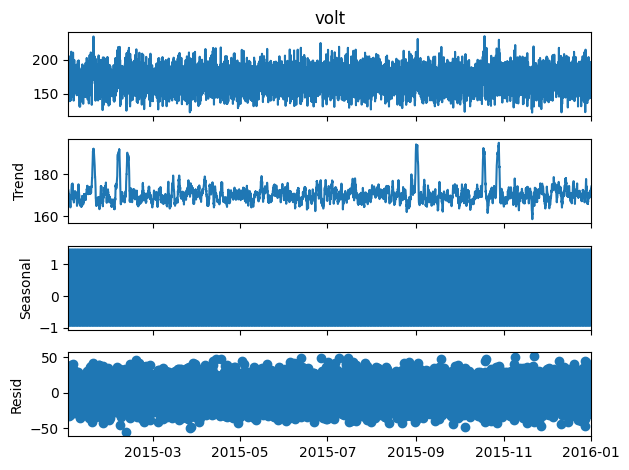

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

df = df_volt_machine_3['volt']

components = seasonal_decompose(df, model='additive',extrapolate_trend='freq')
components.plot()
plt.show()

In [10]:
# import adfuller function
from statsmodels.tsa.stattools import adfuller
import numpy as np

#=============================================
# Build a function to check stationarity
def ISstationarity(df):
    # adfuller(df)[1]:p_value , adf<critical value
       if (adfuller(df)[1]< 0.05) and (adfuller(df)[0] < adfuller(df)[4]['5%']):
        print(' stationary')
       else:
        print('NOT stationary')
#==============================================        
        
#Extract seasonal data        
seasonal = components.seasonal 

#Check stationarity
ISstationarity(seasonal) 

 stationary
